In [20]:
# !pip install pandas
!pip install numpy

In [21]:
!pip install pygad

In [22]:
import pandas as pd
import numpy as np

In [23]:
df = pd.read_csv('QS_WUR_Graphs_With_DataLabels(Аркуш2).csv', delimiter=';')
df

,University,Year,Academic Reputation (AR),Employer Reputation (ER),Faculty Student Ratio (FSR),Citations per Faculty (CPF),International Faculty Ratio (IFR),International Student Ratio (ISR),International Research Network (IRN),Employment Outcomes (GER),Sustainability (SUS)
0,"National Technical University ""Kharkiv Polytec...",2025,"6,5","10,6","54,3","1,3","1,7","20,1","11,4",4,"1,6"


$F(\mathbf{x}) =
0.30 \cdot AR +
0.15 \cdot ER +
0.10 \cdot FSR +
0.20 \cdot CPF +
0.05 \cdot IFR +
0.05 \cdot ISR +
0.05 \cdot IRN +
0.05 \cdot EO +
0.05 \cdot SUS $

In [24]:
WEIGHTS = {
    "Academic Reputation (AR)": 0.30,
    "Employer Reputation (ER)": 0.15,
    "Faculty Student Ratio (FSR)": 0.10,
    "Citations per Faculty (CPF)": 0.20,
    "International Faculty Ratio (IFR)": 0.05,
    "International Student Ratio (ISR)": 0.05,
    "International Research Network (IRN)": 0.05,
    "Employment Outcomes (GER)": 0.05,
    "Sustainability (SUS)": 0.05
}

In [25]:
def compute_overall_score(df: pd.DataFrame) -> pd.DataFrame:
    overall_scores = []

    for _, row in df.iterrows():
        score = 0.0
        for col, weight in WEIGHTS.items():
            value = row.get(col)
            if pd.notna(value):
                try:
                    value_float = float(str(value).replace(',', '.'))
                    score += value_float * weight
                except ValueError:
                    pass
        overall_scores.append(score)

    df["Overall Score"] = overall_scores
    return df

compute_overall_score(df)

,University,Year,Academic Reputation (AR),Employer Reputation (ER),Faculty Student Ratio (FSR),Citations per Faculty (CPF),International Faculty Ratio (IFR),International Student Ratio (ISR),International Research Network (IRN),Employment Outcomes (GER),Sustainability (SUS),Overall Score
0,"National Technical University ""Kharkiv Polytec...",2025,"6,5","10,6","54,3","1,3","1,7","20,1","11,4",4,"1,6",11.17


In [32]:
import pygad
import numpy as np
import pandas as pd

# Поточні значення ХПІ за 2025 рік
x_2025 = {
    "AR": 6.5,
    "ER": 10.6,
    "FSR": 54.3,
    "CPF": 1.3,
    "IFR": 1.7,
    "ISR": 20.1,  # freeze
    "IRN": 11.4,
    "EO": 4.0,
    "SUS": 1.6
}

weights = {
    "AR": 0.30,
    "ER": 0.15,
    "FSR": 0.10,
    "CPF": 0.20,
    "IFR": 0.05,
    "ISR": 0.05,
    "IRN": 0.05,
    "EO": 0.05,
    "SUS": 0.05
}

max_value = {
    "AR": 15,
    "ER": 20,
    "FSR": 70,
    "CPF": 3,
    "IFR": 12,
    "ISR": 20,
    "IRN": 30,
    "EO": 15,
    "SUS": 10
}

max_increase = {
    "AR": 1.0,
    "ER": 1.0,
    "FSR": 1.0,
    "CPF": 0.3,
    "IFR": 2.0,
    "ISR": 0.0,
    "IRN": 5.0,
    "EO": 2.0,
    "SUS": 1.0
}

resource_cost = {
    "AR": 100,
    "ER": 90,
    "FSR": 40,
    "CPF": 30,
    "IFR": 60,
    "ISR": float("inf"),
    "IRN": 20,
    "EO": 20,
    "SUS": 10
}

def compute_qs_score(x):
    return sum(x[i] * w for i, w in enumerate(weights.values()))

def fitness_func(ga_instance, solution, solution_idx):
    keys = list(x_2025.keys())
    x_new = dict(zip(keys, solution))
    total_ru = 0
    details = []

    for k in keys:
        prev = x_2025[k]
        curr = x_new[k]
        delta = curr - prev

        if resource_cost[k] == float("inf"):
            if delta != 0:
                return -10000
        else:
            if delta > 0:
                cost = resource_cost[k] * delta
                total_ru += cost
                details.append((k, prev, curr, delta, resource_cost[k], cost))
                
    if ga_instance.generations_completed % 10 == 0:
        print(f"\n[Generation {ga_instance.generations_completed}]")
        print(f"Total RU used: {total_ru:.2f}")
        print("Details:")
        for d in details:
            print(f"  {d[0]}: {d[1]:.2f} → {d[2]:.2f} (Δ={d[3]:.2f}) × {d[4]} = {d[5]:.2f}")
        print(f"QS Score: {compute_qs_score(solution):.2f}")

    if total_ru > 200:
        return -1000 * (total_ru - 200)

    return compute_qs_score(solution)

gene_space = []
for k in x_2025.keys():
    low = x_2025[k]
    if max_increase[k] == 0:
        gene_space.append([low])
    else:
        high = min(x_2025[k] + max_increase[k], max_value[k])
        gene_space.append({"low": low, "high": high, "step": 0.1})
    
# Запуск GA
ga_instance = pygad.GA(
    num_generations=500,
    num_parents_mating=20,
    fitness_func=fitness_func,
    sol_per_pop=45,
    num_genes=9,
    gene_space=gene_space,
    mutation_percent_genes=20,
    mutation_type="random",
    random_mutation_min_val=0,
    random_mutation_max_val=1,
    stop_criteria="saturate_10"
)

ga_instance.run()

solution, qs_score, _ = ga_instance.best_solution()
x_2026 = dict(zip(x_2025.keys(), solution))

print("\nНайкраще рішення на 2026 рік:")
for k in x_2026:
    print(f"{k}: {x_2026[k]:.2f} (було: {x_2025[k]:.2f})")

print(f"\nQS Overall Score (2026): {qs_score:.2f}")

result_df = pd.DataFrame({
    "Показник": x_2025.keys(),
    "2025": x_2025.values(),
    "2026 (оптимізовано)": solution,
    "Приріст": [solution[i] - list(x_2025.values())[i] for i in range(9)]
})

print("\n", result_df)


[Generation 0]
Total RU used: 141.00
Details:
  AR: 6.50 → 6.70 (Δ=0.20) × 100 = 20.00
  ER: 10.60 → 10.70 (Δ=0.10) × 90 = 9.00
  FSR: 54.30 → 54.90 (Δ=0.60) × 40 = 24.00
  CPF: 1.30 → 1.50 (Δ=0.20) × 30 = 6.00
  IRN: 11.40 → 14.50 (Δ=3.10) × 20 = 62.00
  EO: 4.00 → 4.80 (Δ=0.80) × 20 = 16.00
  SUS: 1.60 → 2.00 (Δ=0.40) × 10 = 4.00
QS Score: 11.56

[Generation 0]
Total RU used: 106.00
Details:
  AR: 6.50 → 6.60 (Δ=0.10) × 100 = 10.00
  ER: 10.60 → 10.70 (Δ=0.10) × 90 = 9.00
  FSR: 54.30 → 54.40 (Δ=0.10) × 40 = 4.00
  CPF: 1.30 → 1.60 (Δ=0.30) × 30 = 9.00
  IFR: 1.70 → 2.40 (Δ=0.70) × 60 = 42.00
  IRN: 11.40 → 12.00 (Δ=0.60) × 20 = 12.00
  EO: 4.00 → 4.60 (Δ=0.60) × 20 = 12.00
  SUS: 1.60 → 2.40 (Δ=0.80) × 10 = 8.00
QS Score: 11.42

[Generation 0]
Total RU used: 180.00
Details:
  AR: 6.50 → 6.60 (Δ=0.10) × 100 = 10.00
  ER: 10.60 → 10.90 (Δ=0.30) × 90 = 27.00
  FSR: 54.30 → 54.80 (Δ=0.50) × 40 = 20.00
  CPF: 1.30 → 1.50 (Δ=0.20) × 30 = 6.00
  IFR: 1.70 → 2.40 (Δ=0.70) × 60 = 42.00
  IR

In [33]:
from pprint import pprint

print("\nGene Space для кожного показника:")
pprint(gene_space)


Gene Space для кожного показника:
[{'high': 7.5, 'low': 6.5, 'step': 0.1},
 {'high': 11.6, 'low': 10.6, 'step': 0.1},
 {'high': 55.3, 'low': 54.3, 'step': 0.1},
 {'high': 1.6, 'low': 1.3, 'step': 0.1},
 {'high': 3.7, 'low': 1.7, 'step': 0.1},
 [20.1],
 {'high': 16.4, 'low': 11.4, 'step': 0.1},
 {'high': 6.0, 'low': 4.0, 'step': 0.1},
 {'high': 2.6, 'low': 1.6, 'step': 0.1}]


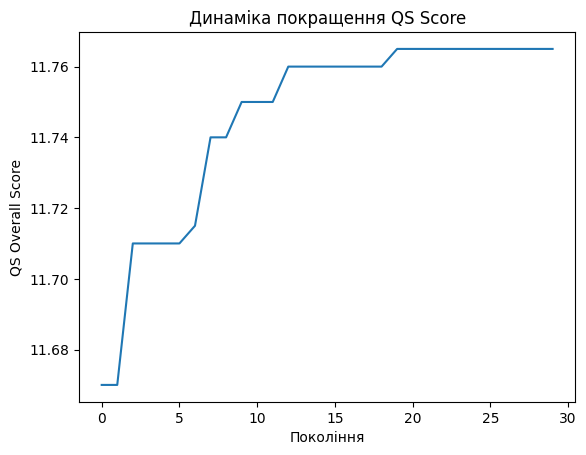

In [34]:
import matplotlib.pyplot as plt

plt.plot(ga_instance.best_solutions_fitness)
plt.xlabel("Покоління")
plt.ylabel("QS Overall Score")
plt.title("Динаміка покращення QS Score")
plt.show()